In [9]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:


df = pd.read_excel('ativos_tratados.xlsx')

In [11]:
df.head()

,Data,NTNB-2029P,NTNB-2050P,DI1F27_preco,DI1F30_preco,T10_preco,CNY,DOL,EUR,S&P500,IBOV
0,2024-01-23,4341.021,4491.526,748.928889,540.570665,667.292724,7.1674,4.9503,1.0854,4864.60,128262.52
1,2024-01-24,4341.021,4499.201,749.625818,541.326949,664.224487,7.1623,4.9328,1.0885,4868.55,127815.70
2,2024-01-25,4352.082,4506.861,751.943274,543.683846,667.921070,7.1799,4.9166,1.0846,4894.16,128168.73
3,2024-01-26,4352.082,4520.395,753.201208,545.169552,666.709842,7.1885,4.9109,1.0853,4890.97,128967.32
4,2024-01-29,4352.082,4512.293,752.378592,543.387151,670.776028,7.1875,4.9480,1.0833,4927.93,128502.66



| Fator de risco (driver econômico) | Instrumento / Código | Posição possível          | Interpretação prática                                                                    |
| --------------------------------- | -------------------- | ------------------------- | ---------------------------------------------------------------------------------------- |
| **IPCA** (inflação real)          | NTN-B (2029, 2050)   | **Aplicado** (long preço) | Proteção contra inflação + duration longa (= sensível à curva real)                      |
| **Pré** (juros prefixados BRL)    | DI1F27, DI1F30       | **Aplicado / Tomado**     | Exposição à Selic futura. “Aplicado” = apostando em *queda* dos juros; “Tomado” = *alta* |
| **Treasury** (10 y US)            | T10                  | **Comprado / Vendido**    | Duration em USD, sensível a Fed Funds                                                    |
| **Câmbio**                        | DOL, EUR, CNY        | **Comprado / Vendido**    | Proteção cambial ou aposta direcional                                                    |
| **Renda variável EUA**            | S&P500 (ISP)         | **Comprado / Vendido**    | Beta-equity global                                                                       |
| **Renda variável BR**             | IBOV (IND)           | **Comprado / Vendido**    | Proxy de bolsa doméstica                                                                 |


In [12]:
df_prices = df.set_index('Data').copy()
log_returns = np.log(df_prices / df_prices.shift(1))

In [19]:
# Define as classes de ativos e os ativos correspondentes
classes_ativos = {
    "IPCA (inflação real)": ["NTNB-2029P", "NTNB-2050P"],
    "Pré (juros prefixados BRL)": ["DI1F27_preco", "DI1F30_preco"],
    "Treasury (10 y US)": ["T10_preco"],
    "Câmbio": ["DOL", "EUR", "CNY"],
    "Renda variável EUA": ["S&P500"],
    "Renda variável BR": ["IBOV"]
}

# Cria gráficos para cada classe de ativos
for classe, ativos in classes_ativos.items():
    fig = go.Figure()
    for ativo in ativos:
        fig.add_trace(go.Scatter(x=df_prices.index, y=df_prices[ativo], mode='lines', name=ativo))
    
    fig.update_layout(
        title=f"Classe de Ativos: {classe}",
        xaxis_title="Data",
        yaxis_title="Preço",
        template="plotly_white",
        height=600,
        hovermode="x unified"
    )
    
    fig.show()

In [13]:
mu = log_returns.mean() * 252  # Anualiza a média dos retornos logarítmicos diários
S = log_returns.cov() * 252
correlation_matrix = log_returns.corr()

In [14]:
mu_df = mu.to_frame(name="Retorno Anual")
print(mu_df)

              Retorno Anual
NTNB-2029P        -0.000213
NTNB-2050P        -0.060237
DI1F27_preco       0.060263
DI1F30_preco       0.023083
T10_preco         -0.004355
CNY                0.001896
DOL                0.067026
EUR                0.040572
S&P500             0.164718
IBOV               0.025178


In [15]:
fig = go.Figure()

for col in log_returns.columns:
    fig.add_trace(go.Scatter(x=log_returns.index, y=log_returns[col], mode='lines', name=col))

fig.update_layout(
    title="Retornos Logarítmicos dos Ativos",
    xaxis_title="Data",
    yaxis_title="Log Retorno Diário",
    template="plotly_white",
    height=600,
    hovermode="x unified"
)

fig.show()

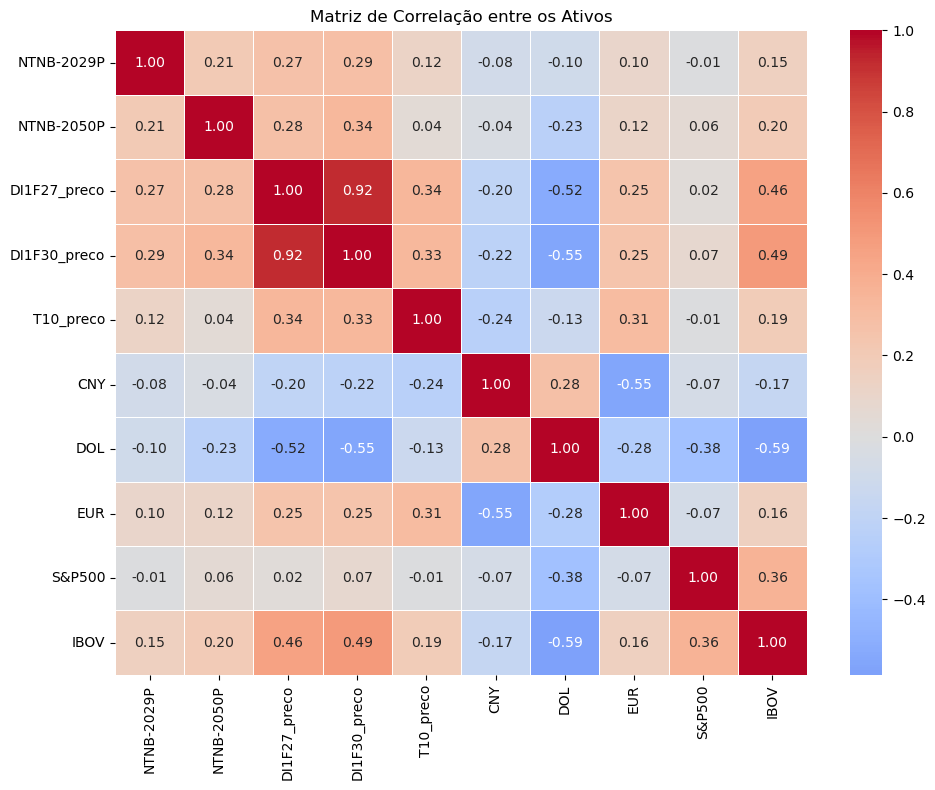

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, center=0)
plt.title("Matriz de Correlação entre os Ativos")
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize

# --- 1) Preparar dados ---
# Se já tiver o DataFrame 'df' igual ao que mandou, pule o read_csv
# df = pd.read_csv("sua_base.csv")

df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values('Data').set_index('Data')

cols = ["NTNB-2029P","NTNB-2050P","DI1F27_preco","DI1F30_preco",
        "T10_preco","CNY","DOL","EUR","S&P500","IBOV"]
prices = df[cols].astype(float)

# Retornos log e anualização
logret = np.log(prices / prices.shift(1)).dropna()
mu = logret.mean() * 252                      # retorno esperado anual
# Covariância com shrinkage Ledoit-Wolf (mais estável)
lw = LedoitWolf().fit(logret.values)
S = pd.DataFrame(lw.covariance_, index=cols, columns=cols) * 252

rf = 0.15                                     # CDI 15% a.a.

# --- 2) Otimização: Sharpe máximo, long-only, soma=1, c/ limites por grupo ---
n = len(cols)

def neg_sharpe(w):
    excess = w @ mu.values - rf
    vol = np.sqrt(w @ S.values @ w)
    return -excess / (vol + 1e-12)

cons = [{'type':'eq', 'fun': lambda w: np.sum(w) - 1}]
bnds = [(0, 1)] * n

# (Opcional) limites por classe – ajuste a seu gosto
grupos = {
    'IPCA+Pré': ["NTNB-2029P","NTNB-2050P","DI1F27_preco","DI1F30_preco"],
    'Treasury': ["T10_preco"],
    'Moedas':   ["CNY","DOL","EUR"],
    'Ações':    ["S&P500","IBOV"],
}
limites = {'IPCA+Pré':0.60, 'Treasury':0.30, 'Moedas':0.25, 'Ações':0.40}

for g, names in grupos.items():
    idx = [cols.index(c) for c in names]
    cons.append({'type':'ineq', 'fun': lambda w, idx=idx, lim=limites[g]: lim - np.sum(w[idx])})

w0 = np.repeat(1/n, n)
res = minimize(neg_sharpe, w0, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter':1000})
w = pd.Series(res.x, index=cols)

# --- 3) Métricas do portfólio ---
ret_esp = float(w @ mu)
vol_esp = float(np.sqrt(w @ S @ w))
sharpe  = (ret_esp - rf) / vol_esp

print("Pesos ótimos (Sharpe máx) — com Ledoit-Wolf:")
print((w*100).round(2).astype(str) + "%")
print(f"\nRetorno esp.: {ret_esp:.2%} | Vol.: {vol_esp:.2%} | Sharpe: {sharpe:.2f}")


Pesos ótimos (Sharpe máx) — com Ledoit-Wolf:
NTNB-2029P       0.0%
NTNB-2050P       0.0%
DI1F27_preco    60.0%
DI1F30_preco     0.0%
T10_preco        0.0%
CNY              0.0%
DOL              0.0%
EUR              0.0%
S&P500          40.0%
IBOV             0.0%
dtype: object

Retorno esp.: 10.20% | Vol.: 7.19% | Sharpe: -0.67
